In [73]:
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
import os
from tensorflow.keras.optimizers import RMSprop

In [74]:
import fluidsynth

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [4]:
#import all the file names
filenames = glob.glob(str("MIDI/pop/**/*.mid"))
# filenames = glob.glob(str("/home/jayden/projects/project_lyrics/MIDI/pop/**/*.mid"))
print('Number of files: ', len(filenames))
sample_file = filenames[5]
print(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)

Number of files:  2898
MIDI/pop/Romantics/GangnamStyle.mid


In [5]:
#악기 종류 찾아내기
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

for num in range(len(pm.instruments)):
    print('All instruments:' , pretty_midi.program_to_instrument_name(pm.instruments[num].program))

Number of instruments: 12
Instrument name: Celesta
All instruments: Celesta
All instruments: Lead 2 (sawtooth)
All instruments: Lead 1 (square)
All instruments: Lead 1 (square)
All instruments: Synth Brass 1
All instruments: Applause
All instruments: String Ensemble 1
All instruments: Rock Organ
All instruments: Melodic Tom
All instruments: Reverse Cymbal
All instruments: Lead 1 (square)
All instruments: Distortion Guitar


In [6]:
def count_instruments(file_list):
    instrument_counts = {}  # Dictionary to store instrument counts for each file
    files_to_delete = []
    
    for file_name in file_list:
        try:
            pm = pretty_midi.PrettyMIDI(file_name)
            file_instrument_counts = {}  # Dictionary to store instrument counts for the current file
            for instrument in pm.instruments:
                instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
                # file_instrument_counts[instrument_name] = file_instrument_counts.get(instrument_name, 0) + 1
                file_instrument_counts[instrument_name] = 1
            
            # Store instrument counts for the current file in the main dictionary
            # instrument_counts[os.path.basename(file_name)] = file_instrument_counts
            instrument_counts[file_name] = file_instrument_counts
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
            # Add the file to the list of files to delete
            files_to_delete.append(file_name)
        
    # Delete the files with errors
    for file_to_delete in files_to_delete:
        os.remove(file_to_delete)

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame.from_dict(instrument_counts, orient='index')
    
    # Fill missing values with zeros
    df.fillna(0, inplace=True)
    
    return df

instrument_counts_df = count_instruments(filenames)




/home/jayden/miniconda3/envs/aimusic/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [7]:
#in case I want additional index line with number
# instrument_counts_df.reset_index(inplace=True)

In [8]:
# instrument_counts_df.astype('int32')
instrument_counts_df.head()

,Tango Accordion,Electric Bass (finger),Electric Guitar (jazz),Acoustic Guitar (steel),Bright Acoustic Piano,Synth Choir,String Ensemble 1,Acoustic Grand Piano,Electric Grand Piano,Shakuhachi,...,Slap Bass 2,FX 6 (goblins),Orchestra Hit,FX 3 (crystal),Marimba,Dulcimer,Tinkle Bell,Lead 7 (fifths),Koto,Agogo
MIDI/pop/Marcels/IdLoveYouToWantMe.mid,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MIDI/pop/Jann Arden/GoldDustWoman.mid,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MIDI/pop/Gary Wright/AprilinParis.mid,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MIDI/pop/Sam Smith/GardenParty.mid,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MIDI/pop/BBMak/CouldItBeMagic.mid,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
top_instru = instrument_counts_df.sum().nlargest(20)
print(top_instru.index[0])

Acoustic Grand Piano


In [80]:
instrument_counts_df.sum().index

Index(['Tango Accordion', 'Electric Bass (finger)', 'Electric Guitar (jazz)',
       'Acoustic Guitar (steel)', 'Bright Acoustic Piano', 'Synth Choir',
       'String Ensemble 1', 'Acoustic Grand Piano', 'Electric Grand Piano',
       'Shakuhachi',
       ...
       'Slap Bass 2', 'FX 6 (goblins)', 'Orchestra Hit', 'FX 3 (crystal)',
       'Marimba', 'Dulcimer', 'Tinkle Bell', 'Lead 7 (fifths)', 'Koto',
       'Agogo'],
      dtype='object', length=128)

In [10]:
#나중에 인덱스 찾아서 특정 악기 데이터 뽑기위해서 테스트
test = instrument_counts_df.index[instrument_counts_df[top_instru.index[0]] == 1].tolist()
print(test)

['MIDI/pop/Marcels/IdLoveYouToWantMe.mid', 'MIDI/pop/Jann Arden/GoldDustWoman.mid', 'MIDI/pop/Sam Smith/GardenParty.mid', 'MIDI/pop/BBMak/CouldItBeMagic.mid', 'MIDI/pop/Patti LaBelle/BanksOfTheOhio.mid', 'MIDI/pop/Aha/RollingThunder.mid', 'MIDI/pop/Connie Francis/Outsider.mid', 'MIDI/pop/Eve 6/TiredOfBeingSorry.mid', 'MIDI/pop/Gloria Gaynor/GetItRightNextTime.mid', 'MIDI/pop/Roy Orbison/BlesstheBrokenRoad.mid', 'MIDI/pop/Hole/KidsWithGuns.mid', 'MIDI/pop/Sade/Maria.mid', 'MIDI/pop/Simple Plan/BlueBayou.mid', 'MIDI/pop/Falco/DontLetItBringYouDown.mid', 'MIDI/pop/Aaron Carter/OneBetter.mid', 'MIDI/pop/Culture Club/InTheStillOfTheNight.mid', 'MIDI/pop/Dave Clark Five/GirlsJustWannaHaveFun.mid', 'MIDI/pop/Leann Rimes/Firework.mid', 'MIDI/pop/Annie Villeneuve/DontLetItBringYouDown.mid', 'MIDI/pop/Amanda Lear/Faith.mid', 'MIDI/pop/Eurythmics/BlueKentucky.mid', 'MIDI/pop/Marcels/IWantYouToLoveMe.mid', 'MIDI/pop/Lovin Spoonful/HangingByAMoment.mid', 'MIDI/pop/Lovin Spoonful/Simon.mid', 'MIDI/p

In [11]:
# training model requires 3 variables (pitch, step, duration)
# pitch : perceptual quality of the sound as a midi note
# step : time elapsed from previous note or start of the track
# duration : duration of the current note
# 미디 파일에서 음표 추출하는 부분.

# return pd.DataFrame
def midi_to_notes(midi_file: str, instrument_name: str):
  try:
    pm = pretty_midi.PrettyMIDI(midi_file)
    
    # check if the specific instrument exist in the MIDI file
    instrument = None
    for inst in pm.instruments:
      if pretty_midi.program_to_instrument_name(inst.program) == instrument_name:
          instrument = inst
          break
    if instrument is None:
      # pass
      raise ValueError(f"Instrument '{instrument_name}' not found in the MIDI file")
      
      # raise ValueError()

    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
      start = note.start
      end = note.end
      notes['pitch'].append(note.pitch)
      notes['start'].append(start)
      notes['end'].append(end)
      notes['step'].append(start - prev_start)
      notes['duration'].append(end - start)
      prev_start = start
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})
  except Exception as e:
    print(f"Error occurred while processing file {midi_file}: {e}")


In [12]:
#미디 파일 생성

def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name)) #피아노를 넣으면 피아노가 있는 경우에 그것의 맞는 Pretty midi instrument 숫자를 리턴

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [47]:
#오디오를 30초간 들을수 있는 펑션
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

데이터 생성

In [81]:
## get alllllll instruments
instrument_counts_df.sum().index

all_notes_by_instruments = {}  # Dictionary to store notes for each instrument

# Loop over each instrument entry in top_instru
for instru_entry in instrument_counts_df.sum().index:
    all_notes_list = []  # List to store DataFrame objects for each file
    temp = instrument_counts_df.index[instrument_counts_df[instru_entry] == 1].to_list()
    for f in temp:
        notes = midi_to_notes(f, instru_entry)
        if notes is not None:
            all_notes_list.append(notes)
    all_notes_by_instruments[instru_entry] = all_notes_list

# Concatenate DataFrames separately for each instrument
all_notes_by_instruments_df = {}
for instrument_name, notes_list in all_notes_by_instruments.items():
    all_notes_by_instruments_df[instrument_name] = pd.concat(notes_list, ignore_index=True)

# access notes for each instrument:
for instrument_name, notes_df in all_notes_by_instruments_df.items():
    print(f"Notes for instrument '{instrument_name}':")
    print(notes_df)

/home/jayden/miniconda3/envs/aimusic/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [14]:
# get top 20 instruments
all_notes_by_instrument = {}  # Dictionary to store notes for each instrument

# Loop over each instrument entry in top_instru
for instru_entry in top_instru.index:
    all_notes_list = []  # List to store DataFrame objects for each file
    temp = instrument_counts_df.index[instrument_counts_df[instru_entry] == 1].to_list()
    for f in temp:
        notes = midi_to_notes(f, instru_entry)
        if notes is not None:
            all_notes_list.append(notes)
    all_notes_by_instrument[instru_entry] = all_notes_list

# Concatenate DataFrames separately for each instrument
all_notes_by_instrument_df = {}
for instrument_name, notes_list in all_notes_by_instrument.items():
    all_notes_by_instrument_df[instrument_name] = pd.concat(notes_list, ignore_index=True)

# access notes for each instrument:
for instrument_name, notes_df in all_notes_by_instrument_df.items():
    print(f"Notes for instrument '{instrument_name}':")
    print(notes_df)

/home/jayden/miniconda3/envs/aimusic/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Notes for instrument 'Acoustic Grand Piano':
         pitch       start         end      step  duration
0           35    3.116884    4.038962  0.000000  0.922078
1           35    4.512988    4.655845  1.396104  0.142857
2           35    4.675326    4.948053  0.162338  0.272727
3           35    5.064936    5.487015  0.389610  0.422078
4           35    5.844157    6.019482  0.779221  0.175325
...        ...         ...         ...       ...       ...
2896782     42  217.607050  217.639543  0.355182  0.032493
2896783     45  217.802437  217.837222  0.195387  0.034785
2896784     45  217.998103  218.035028  0.195666  0.036926
2896785     57  218.004625  218.042045  0.006522  0.037420
2896786     36  218.004625  218.042045  0.000000  0.037420

[2896787 rows x 5 columns]
Notes for instrument 'Electric Bass (finger)':
        pitch       start         end      step  duration
0          34    3.116884    3.701300  0.000000  0.584416
1          34    3.896105    4.396105  0.779221  0.50000

In [43]:
len(all_notes_by_instrument_df)

20

In [15]:
# 악기 고유 빼온거 전부 봐보기.
all_notes_by_instrument_df['Acoustic Grand Piano']

,pitch,start,end,step,duration
0,35,3.116884,4.038962,0.000000,0.922078
1,35,4.512988,4.655845,1.396104,0.142857
2,35,4.675326,4.948053,0.162338,0.272727
3,35,5.064936,5.487015,0.389610,0.422078
4,35,5.844157,6.019482,0.779221,0.175325
...,...,...,...,...,...
2896782,42,217.607050,217.639543,0.355182,0.032493
2896783,45,217.802437,217.837222,0.195387,0.034785
2896784,45,217.998103,218.035028,0.195666,0.036926
2896785,57,218.004625,218.042045,0.006522,0.037420


In [16]:
all_notes_top = all_notes_by_instrument_df[top_instru.index[0]]

n_notes = len(all_notes_top)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 2896787


In [17]:

#create tensor dataset
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes_top[key] for key in key_order], axis=1)

In [18]:
train_notes

array([[3.50000000e+01, 0.00000000e+00, 9.22078183e-01],
       [3.50000000e+01, 1.39610429e+00, 1.42857183e-01],
       [3.50000000e+01, 1.62337708e-01, 2.72727350e-01],
       ...,
       [4.50000000e+01, 1.95665859e-01, 3.69255729e-02],
       [5.70000000e+01, 6.52219531e-03, 3.74195417e-02],
       [3.60000000e+01, 0.00000000e+00, 3.74195417e-02]])

In [19]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

2024-04-09 14:37:56.121073: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: UNKNOWN ERROR (100)


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [20]:
#노트 시퀀스로 다음 음표 예측 훈련.
#기존에 있는 노트들을 시퀀스로 묶고 그것으로 다음 시퀀스 예측.
#시퀀스가 길수록 한번에 묶여있는 노트의 숫자 증가.

def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [21]:
#시퀀스 길이 조정. 
seq_length = 25 #변환 가능.
vocab_size = 128 #pretty_midi 의 최대 피치 수.
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(30, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [22]:
batch_size = 128
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [23]:
train_ds.element_spec

(TensorSpec(shape=(64, 30, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## 모델 생성 및 학습

In [24]:
# 음수 말고 양수쪽으로 움직이게 weight 를 더 주기.

def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [25]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     67,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
#cheecking the loss model. 
losses = model.evaluate(train_ds, return_dict=True)
losses

2024-04-09 14:38:06.557117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 109305 of 2896757
2024-04-09 14:38:16.557203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 220232 of 2896757
2024-04-09 14:38:36.557104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 443153 of 2896757
2024-04-09 14:38:46.557170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 549917 of 2896757
2024-04-09 14:39:06.557200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 775002 of 2896757
2024-04-09 14:39:26.557120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle 

     27/Unknown 262s 6ms/step - loss: 5.8376

2024-04-09 14:42:17.789276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


45261/45261 ━━━━━━━━━━━━━━━━━━━━ 501s 5ms/step - loss: 6.4025


2024-04-09 14:46:17.098058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/jayden/miniconda3/envs/aimusic/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'loss': 6.430893421173096}

In [27]:
# noticed that the loss model has too much weight on pitch.
model.compile(loss=loss,
    loss_weights={
        'pitch': 0.1,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)
model.evaluate(train_ds, return_dict=True)

45261/45261 ━━━━━━━━━━━━━━━━━━━━ 242s 5ms/step - loss: 2.0414


2024-04-09 14:50:19.134788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


{'loss': 2.069920063018799}

In [31]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]



In [32]:
%%time
epochs = 50

history = model.fit(train_ds, epochs=epochs, callbacks=callbacks,)

Epoch 1/50
45261/45261 ━━━━━━━━━━━━━━━━━━━━ 555s 12ms/step - loss: 0.9461
Epoch 2/50
    9/45261 ━━━━━━━━━━━━━━━━━━━━ 10:59 15ms/step - loss: 0.4407

2024-04-09 15:02:28.001446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


45261/45261 ━━━━━━━━━━━━━━━━━━━━ 531s 12ms/step - loss: 0.9033
Epoch 3/50
   11/45261 ━━━━━━━━━━━━━━━━━━━━ 8:50 12ms/step - loss: 0.4261

2024-04-09 15:11:18.830758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


45261/45261 ━━━━━━━━━━━━━━━━━━━━ 501s 11ms/step - loss: 0.9110
Epoch 4/50
   16/45261 ━━━━━━━━━━━━━━━━━━━━ 8:01 11ms/step - loss: 0.4099

2024-04-09 15:19:39.587020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


45261/45261 ━━━━━━━━━━━━━━━━━━━━ 497s 11ms/step - loss: 0.9173
Epoch 5/50
   10/45261 ━━━━━━━━━━━━━━━━━━━━ 9:51 13ms/step - loss: 0.4533 

2024-04-09 15:27:56.842166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


45261/45261 ━━━━━━━━━━━━━━━━━━━━ 494s 11ms/step - loss: 0.9591
Epoch 6/50
   11/45261 ━━━━━━━━━━━━━━━━━━━━ 8:39 11ms/step - loss: 0.5992

2024-04-09 15:36:11.011383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


45261/45261 ━━━━━━━━━━━━━━━━━━━━ 501s 11ms/step - loss: 1.0355
Epoch 7/50
   11/45261 ━━━━━━━━━━━━━━━━━━━━ 8:24 11ms/step - loss: 0.4903

2024-04-09 15:44:32.036198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


45261/45261 ━━━━━━━━━━━━━━━━━━━━ 498s 11ms/step - loss: 1.0010
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.
CPU times: user 1h 40min 36s, sys: 27min, total: 2h 7min 37s
Wall time: 59min 37s


2024-04-09 15:52:50.382858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


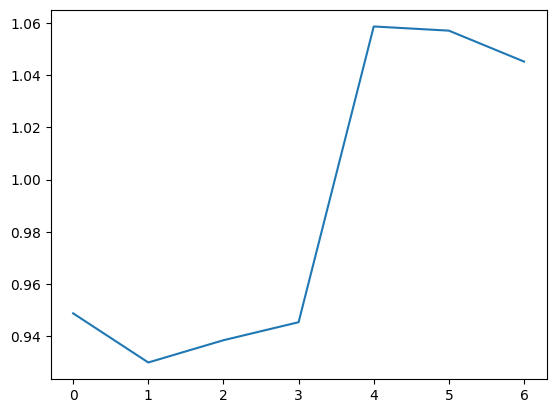

In [33]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [34]:
# 예측을 하려면 노트의 시퀀스를 넣어야함.
# 노트의 시퀀스를 만들어서 넣기.
# 노트 피치는 소프트맥스 함수로 나눠진거에서 샘플로 여러개를 가지고 오고 제일 높은 확률만 가져오지 않음

def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0 #온도가 노트들 랜덤생성하게 하는거 도와주는 펑션

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [44]:
#이런 노래를 넣어서 해보기
raw_notes = midi_to_notes(filenames[0], top_instru.index[0])

In [45]:
#온도, 시작 시퀀스 가지고 바꿔보기.
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

In [50]:
sample_notes

array([[3.50000000e+01, 0.00000000e+00, 9.22078183e-01],
       [3.50000000e+01, 1.39610429e+00, 1.42857183e-01],
       [3.50000000e+01, 1.62337708e-01, 2.72727350e-01],
       [3.50000000e+01, 3.89610500e-01, 4.22078042e-01],
       [3.50000000e+01, 7.79221000e-01, 1.75324725e-01],
       [3.50000000e+01, 3.89610500e-01, 7.46753458e-01],
       [3.50000000e+01, 1.39610429e+00, 1.42857183e-01],
       [3.50000000e+01, 1.62337708e-01, 2.59740333e-01],
       [3.50000000e+01, 3.89610500e-01, 3.89610500e-01],
       [3.50000000e+01, 7.79221000e-01, 1.62337708e-01],
       [3.50000000e+01, 3.89610500e-01, 7.14285917e-01],
       [3.50000000e+01, 1.39610429e+00, 1.42857183e-01],
       [3.50000000e+01, 1.62337708e-01, 3.24675417e-01],
       [3.50000000e+01, 3.89610500e-01, 4.22078042e-01],
       [3.50000000e+01, 7.79221000e-01, 1.75324725e-01],
       [3.50000000e+01, 3.89610500e-01, 1.07142887e+00],
       [3.50000000e+01, 1.55844200e+00, 2.93506577e+00],
       [3.50000000e+01, 3.11688

In [57]:
import random

In [70]:
generated_notes['duration'] = generated_notes['duration'] + 10

In [71]:
generated_notes

,pitch,step,duration,start,end
0,35,0.606871,14.710021,0.606871,0.916892
1,84,0.000000,14.400000,0.606871,0.606871
2,84,0.000000,14.400000,0.606871,0.606871
3,27,0.000000,14.400000,0.606871,0.606871
4,85,0.000000,14.400000,0.606871,0.606871
...,...,...,...,...,...
115,83,0.000000,14.400000,0.606871,0.606871
116,84,0.000000,14.400000,0.606871,0.606871
117,88,0.000000,14.400000,0.606871,0.606871
118,84,0.000000,14.400000,0.606871,0.606871


In [72]:
out_file = 'sample/output3.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)